In [1]:
import asrtoolkit
from asrtoolkit import wer, cer
import cv2
import io
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import numpy as np
from PIL import Image
import pytesseract
import sys
#skimage causing issues with io standard library, hence import as
from skimage import io as ioski
from skimage.color import rgb2gray
from skimage.transform import rotate, resize
import os
from google.cloud import vision
# from google.cloud.vision import types
from dotenv import load_dotenv, find_dotenv
load_dotenv()

False

In [2]:
#following code is for google credentials 

# with open("google.json", "wt") as fp:
#     # write file to /tmp containing all of the cred info
#     fp.write(os.getenv("GOOGLE_CREDS"))

#pass json credentials to access google.cloud
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "google.json"
client = vision.ImageAnnotatorClient()

In [3]:
from deskew import determine_skew

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1696x2200 at 0x321BCA790>


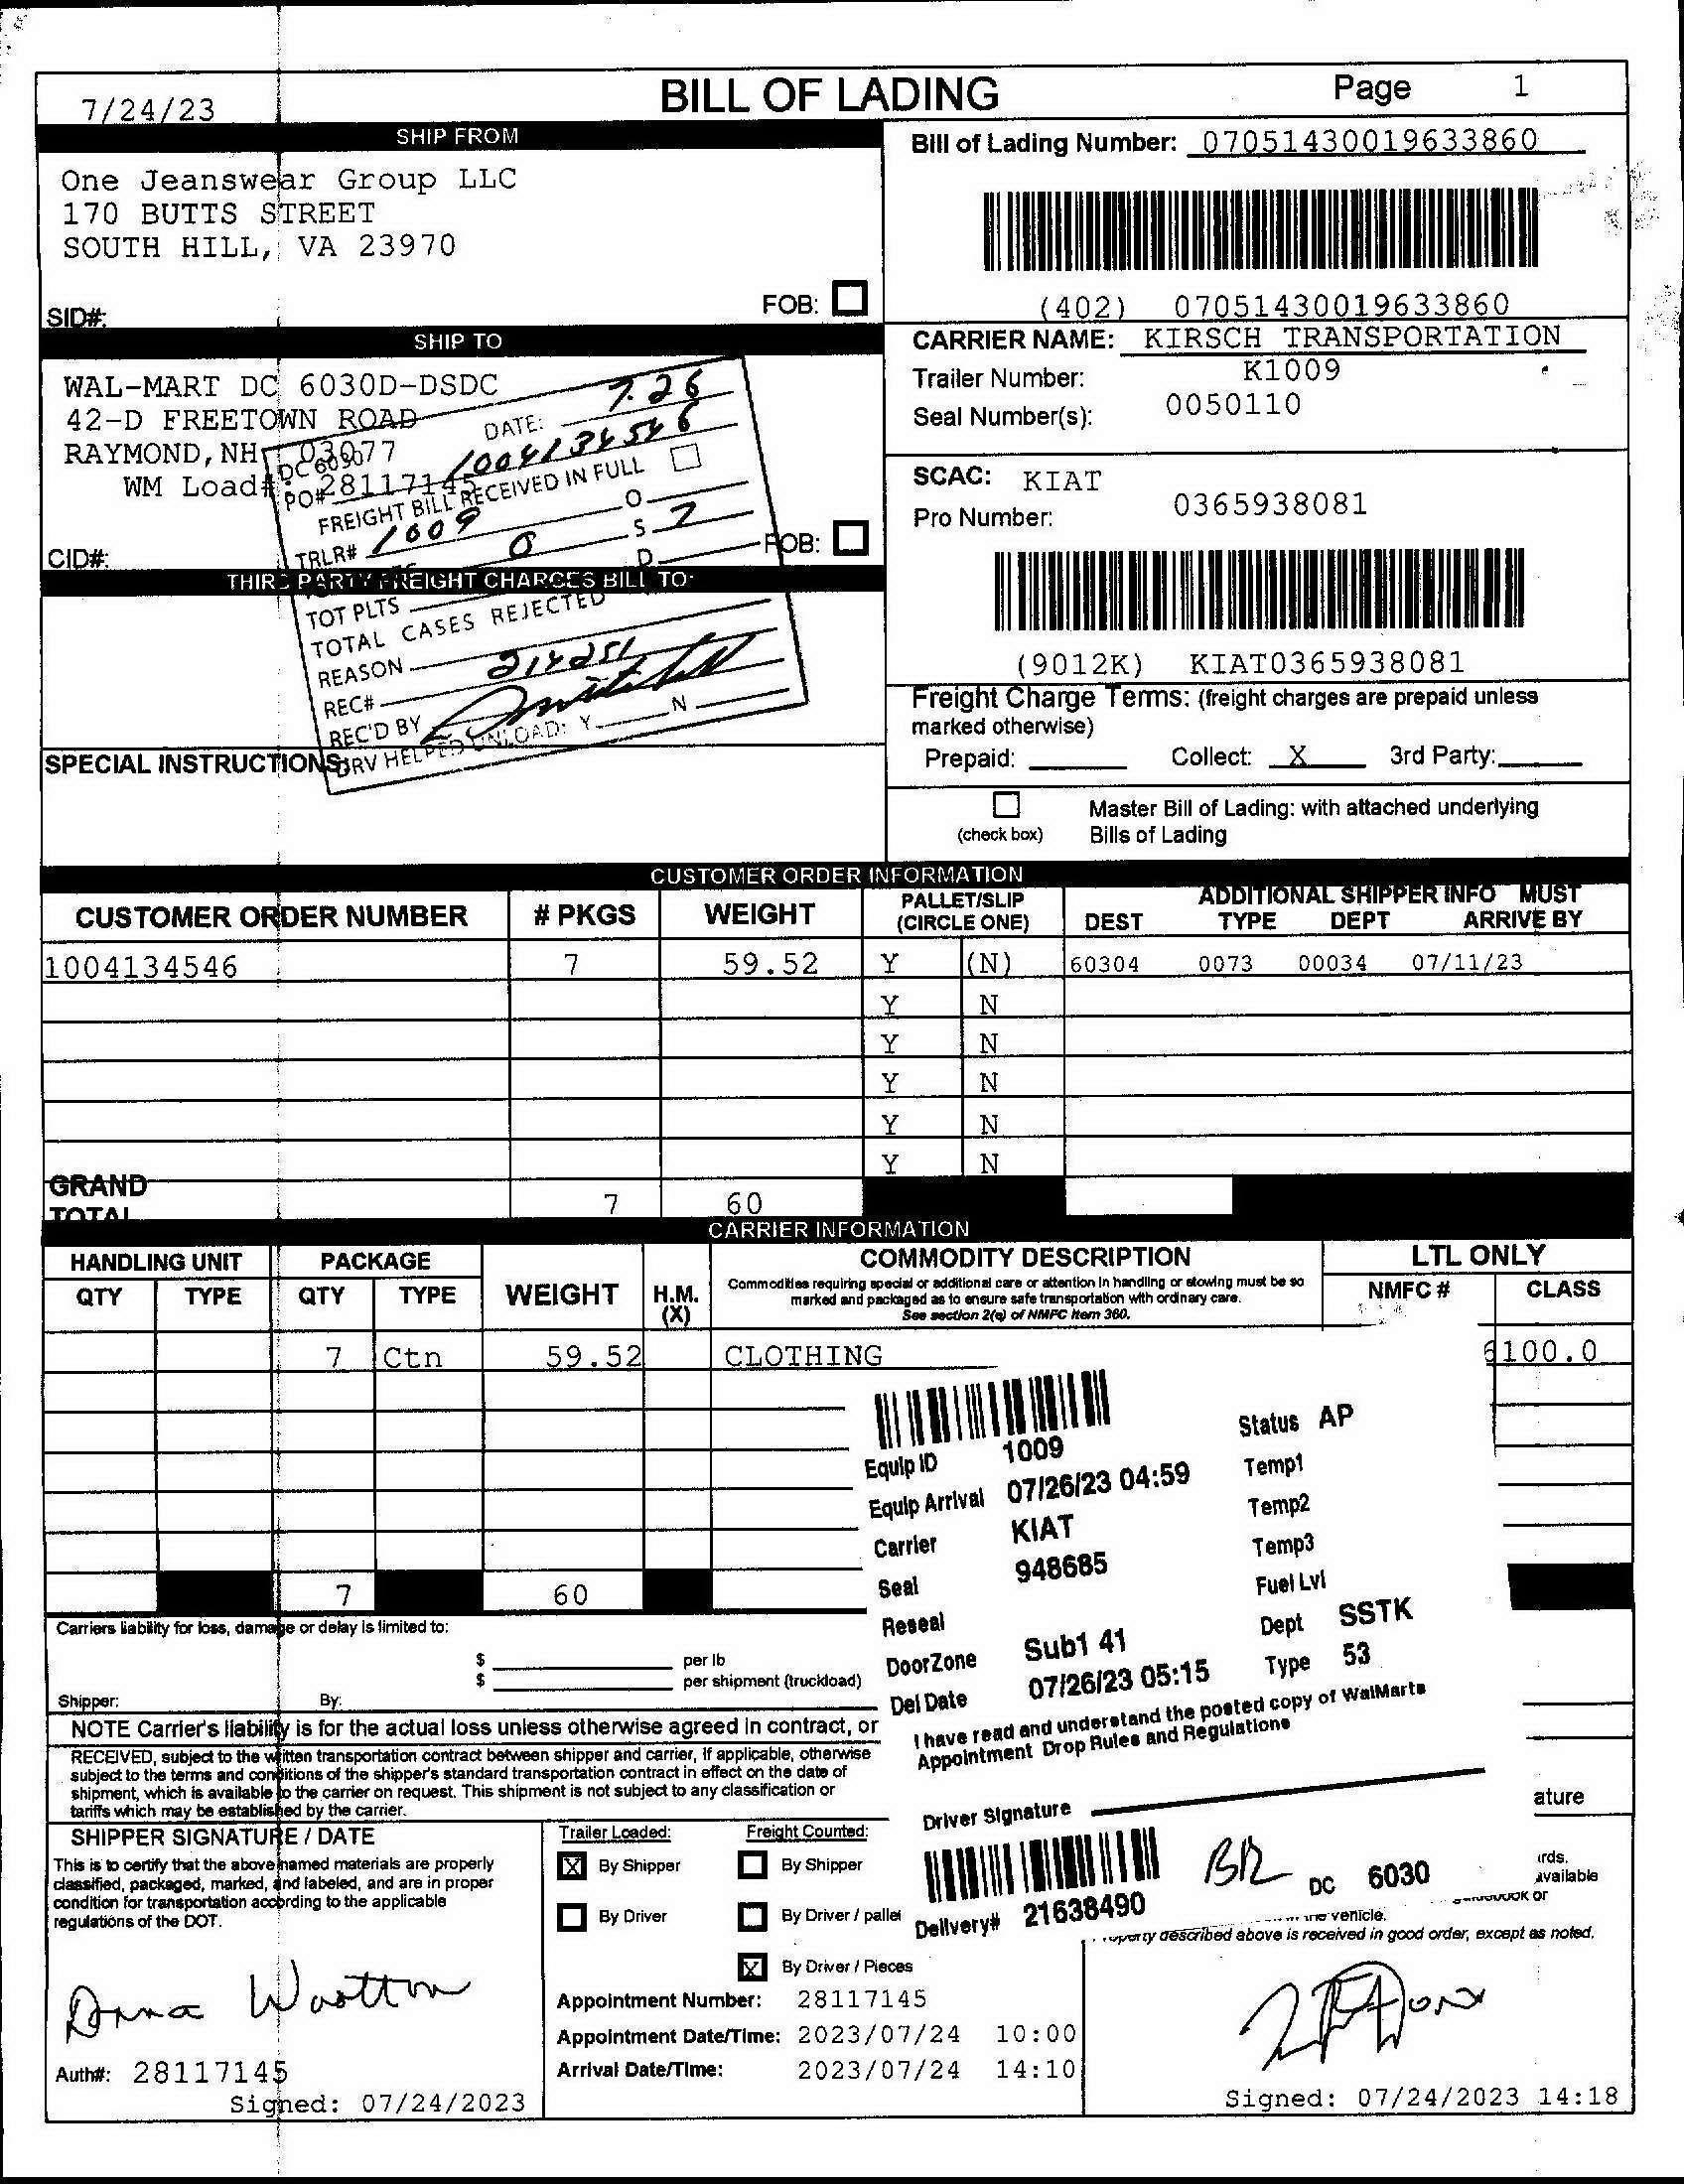

In [4]:
BOL = "BOL_2.jpeg"
outputimage = Image.open(BOL)
print(outputimage)
outputimage

In [5]:
import cv2
import pytesseract
import re

# Load image

img = cv2.imread(BOL)

# Preprocess the image if needed (e.g., resizing, enhancing contrast)

# Use pytesseract to do OCR on the rectangle containing the date
custom_config = r'--oem 3 --psm 6'  # Page segmentation mode 6 for block of text
extracted_text = pytesseract.image_to_string(img, config=custom_config)

# print("Extracted Text:")
# print(extracted_text)

def extract_date_from_ocr(text):
    # Regular expression to match mm/dd/yyyy format
    date_pattern = r'(\d{1,2}/\d{1,2}/\d{4})'
    
    # Search for the date pattern in the text
    matches = re.findall(date_pattern, text)
    
    # Assuming there's only one date in the text, return the first match
    if matches:
        return matches[0]
    else:
        return None
    
BOL_date = extract_date_from_ocr(extracted_text)

if BOL_date:
    print("Date found:", BOL_date)
else:
    print("Date not found in OCR text.")

Date found: 07/24/2023


Saved sub_image_1.jpg
Saved sub_image_2.jpg
Saved sub_image_3.jpg
Saved sub_image_4.jpg
Saved sub_image_5.jpg
Saved sub_image_6.jpg


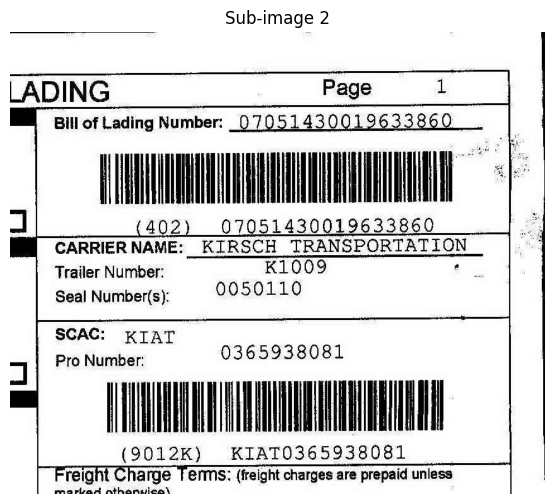

In [6]:
import cv2
import matplotlib.pyplot as plt

# Read the input image
input_image = cv2.imread(BOL)
original_image = input_image.copy()

# Define the number of rows and columns for division
rows = 3
cols = 2

# Calculate the height and width of each sub-image
height = original_image.shape[0] // rows
width = original_image.shape[1] // cols

# List to store the sub-images
sub_images = []

# Divide the original image into sub-images
for r in range(rows):
    for c in range(cols):
        start_row = r * height
        end_row = start_row + height
        start_col = c * width
        end_col = start_col + width
        sub_img = original_image[start_row:end_row, start_col:end_col]
        sub_images.append(sub_img)

# Select and process the second sub-image (index 1)
index = 1  # Second sub-image
sub_img = sub_images[index]

# Display the second sub-image
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(sub_img, cv2.COLOR_BGR2RGB))
plt.title(f'Sub-image {index + 1}')
plt.axis('off')

# Save the second sub-image
for i,img in enumerate(sub_images):
    output_filename = f"sub_image_{i + 1}.jpg"
    cv2.imwrite(output_filename, img)
    print(f"Saved {output_filename}")



In [7]:
#make the imaged aligned at 0 degree

image = ioski.imread("sub_image_2.jpg")
grayscale = rgb2gray(image)
angle = determine_skew(grayscale)
print(angle)
rotated = rotate(image, angle*-1, resize=True) * 255
print(type(rotated))
ioski.imsave("output_deskewed.png", rotated.astype(np.uint8))

0.0
<class 'numpy.ndarray'>


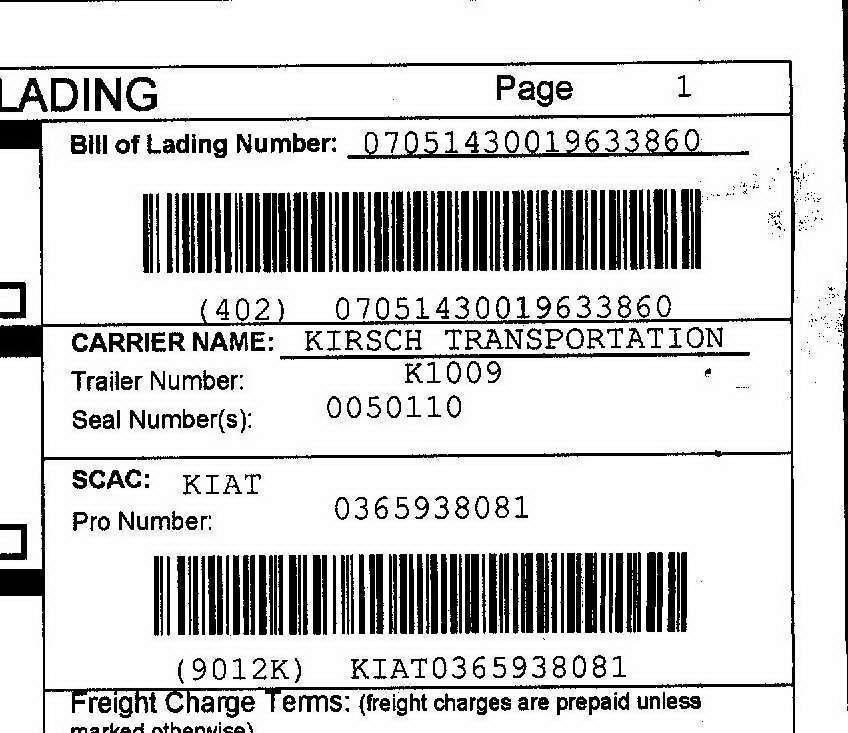

In [8]:
Image.open("output_deskewed.png")

In [9]:
def pre_process_image(image):
    """This function will pre-process a image with: cv2 & deskew
    so it can be process by tesseract"""
    img = cv2.imread(image)
    img = cv2.resize(img, None, fx=.3, fy=.3) #resize using percentage
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #change color format from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #format image to gray scale
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 11) #to remove background
    return img

In [10]:
def img_process(image):
    """This function will deskew"""
    cv2output = io.imread(image)
    angle = determine_skew(cv2output)
    print("angle rotation of image",angle)
    rotated = rotate(cv2output, angle, resize=True) * 255
    return rotated

In [11]:
#use function pre_process_image to output processed image to a saved file.
processed_img = pre_process_image("output_deskewed.png")
cv2.imwrite("output_processed.png",processed_img)
processed_img = pre_process_image(BOL)
cv2.imwrite("output_no_deskewing.png",processed_img)

True

In [12]:
ground_truth = "BILL OF LADING NUMBER:"

In [13]:
#pytesseract no preprocessing
hypothesis0 = pytesseract.image_to_string(BOL)
print("CER, WER, Rate :",cer(ground_truth, hypothesis0),wer(ground_truth, hypothesis0),fuzz.ratio(ground_truth, hypothesis0))
print(hypothesis0)

CER, WER, Rate : 8688.57142857143 4122.222222222223 2
ny. BILL OF LADING Page 1

SHIP EROM Bill of Lading Number: _07051430019633860
ar Group LLC

One Jeanswe

170 BUTTS STREET
SOUTH HILL, VA 23970
402 079051430019633860
SHIP TO CARRIERNAME: KIRSCH TRANSPORTATION

Trailer Number: K1009
Seal Number(s): 0050110

SCAC: KIAT

Pro Number: 0365938081
(9012K) KIAT0365938081

reignt Charge Terms: (freight charges are prepaid unless
marked otherwise)

SPECIAL INSTRUCTIO! 3 av HELPS Prepaid: Collect _X ss rd Party:
0 Master Bill of Lading: with attached underlying
(check box) Bills of Lading

CUSTOMER ORDER INFORMATION

ALLETISLIP RERITIONALCHIPEEE NEO TU
Spaieaee ORDER NUMBER Led WEIGHT (CIRCLE ONE) DEST TYPE DEPT ARRIVE BY

1004134546 60304 0073 00034 07/11/23

i

CARRIER INFORMATION

| HANDLING UNIT |' PACKAGE | COMMODITY DESCRIPTION LTL ONLY

PT Ictn | 59.52 |

TTT votg 8

ip 10
Ee Arrival Lae 04:59 =
Carrier ae
Seal 948685 ct
Reseal sy ae

er subi
Fi ometonsins DHOOM Tonging gg:t5 THE

ippe

In [14]:
#pytesseract out of the box with deskew & rgb2gray
hypothesis1 = pytesseract.image_to_string("output_deskewed.png")
print("CER, WER, Rate :",cer(ground_truth, hypothesis1),wer(ground_truth, hypothesis1),fuzz.ratio(ground_truth, hypothesis1))
print(hypothesis1)

CER, WER, Rate : 1902.857142857143 800.0 7
Bill of Lading Number: _07051430019633860

eT

402 079051430019633860
CARRIERNAME: KIRSCH TRANSPORTATION

Trailer Number: K1009
Seal Number(s): 0050110

SCAC: KIAT
Pro Number. 0365938081

IAA

(9012K) KIATO365938081
jarge Ferms: (freight charges are prepaid unless
marvan nthanagicat




In [15]:
import io
from google.cloud import vision
from difflib import SequenceMatcher
from fuzzywuzzy import fuzz

# Assuming 'client' is your Google Vision API client
client = vision.ImageAnnotatorClient()

# Load image file
with io.open("output_deskewed.png", 'rb') as image_file:
    content = image_file.read()

# Construct an image object
image_v = vision.Image(content=content)

# Perform text detection
response = client.document_text_detection(image=image_v)
annotations = response.full_text_annotation

# Extract words and their bounding boxes
words = []
for page in annotations.pages:
    for block in page.blocks:
        for paragraph in block.paragraphs:
            for word in paragraph.words:
                word_text = ''.join([symbol.text for symbol in word.symbols])
                words.append((word_text, word.bounding_box.vertices))

# Sort words by their vertical position (top to bottom)
words.sort(key=lambda w: (w[1][0].y, w[1][0].x))

# Construct the detected text by reconstructing lines based on vertical position
detected_text = []
current_line = []
last_bottom = words[0][1][0].y

for word, vertices in words:
    if vertices[0].y > last_bottom + 5:  # New line threshold (adjust as needed)
        detected_text.append(' '.join(current_line))
        current_line = [word]
    else:
        current_line.append(word)
    
    last_bottom = vertices[2].y

# Append the last line
if current_line:
    detected_text.append(' '.join(current_line))

# Join all lines into a single string
detected_text = '\n'.join(detected_text)

# Print the reconstructed text
print(detected_text)

# Example of CER, WER, and Fuzzy Ratio calculation (you need to define these functions)
print("CER, WER, Rate :", cer(ground_truth, detected_text), wer(ground_truth, detected_text), fuzz.ratio(ground_truth, detected_text))


Page LADING 1
: 07051430019633860 Lading Number Bill of
07051430019633860 402 ) ( TRANSPORTATION KIRSCH NAME : CARRIER
K1009 Trailer Number :
0050110 Seal Number ( s ) :
SCAC : KIAT 0365938081 Pro Number :
KIAT0365938081 ( 9012K )
prepaid unless Terms : ( freight charges are Freight Charge
marked otherwise )
CER, WER, Rate : 1785.7142857142858 777.7777777777778 8


In [16]:
import re

BOLNo = "NA"
# Function to extract bill of lading number
def extract_bol_number(text):
    # Define regex pattern to capture the number after "BILL OF LADING NUMBER"
    pattern = r'BILL OF LADING NUMBER\s*:\s*(\d+)'

    # Search for the pattern in the text
    match = re.search(pattern, text)
    if match:
        return match.group(1)  # Return the captured number
    else:
        return None  # Return None if not found

# Extract bill of lading number from the text block
bol_number = extract_bol_number(hypothesis1)
if bol_number:
    BOLNo=bol_number
    print(f"Extracted BILL OF LADING NUMBER: {bol_number}")
else:
    print("BILL OF LADING NUMBER not found in the text block.")


BILL OF LADING NUMBER not found in the text block.


In [17]:
import re

# Function to extract bill of lading number

def extract_bol_number(text):
    # Define regex pattern to capture the number after "Bill of Lading Number:"
    pattern = r'Bill of Lading Number:\s*([A-Za-z0-9_]+)'

    # Search for the pattern in the text
    match = re.search(pattern, text)
    if match:
        return match.group(1)  # Return the captured number
    else:
        return None  # Return None if not found

# Extract bill of lading number from the text block
if BOLNo=="NA":
    bol_number = extract_bol_number(hypothesis1)
    if bol_number:
        BOLNo=bol_number
        print(f"Extracted Bill of Lading Number: {bol_number}")
    else:
        print("Bill of Lading Number not found in the text block.")


Extracted Bill of Lading Number: _07051430019633860


In [18]:
import re

# Split the text into lines
lines = hypothesis1.strip().split('\n')
TLR = "NA"
# Initialize a variable to store the line containing "Seal Number"
trailer_number_line = None
# Iterate through lines to find the line containing "Seal Number"
for line in lines:
    if "Trailer Number" in line:
        trailer_number_line = line
        break

if trailer_number_line:
    print(f"Complete line containing trailer Number: {trailer_number_line}")
    
    # Extract seal number using regex
    trailer_number = re.search(r'\d{3,}', trailer_number_line)
    if trailer_number:
        print(f"Extracted trailer Number: {trailer_number.group()}")
        TLR=trailer_number.group()
    else:
        print("trailer Number not found in the line.")
else:
    print("trailer Number line not found.")



Complete line containing trailer Number: Trailer Number: K1009
Extracted trailer Number: 1009


In [19]:
import re

# Split the text into lines
lines = hypothesis1.strip().split('\n')
SEAL = "NA"
# Initialize a variable to store the line containing "Seal Number"
seal_number_line = None
seal_number = None
# Iterate through lines to find the line containing "Seal Number"
for line in lines:
    if "Seal Number" in line:
        seal_number_line = line
        break

if seal_number_line:
    print(f"Complete line containing Seal Number: {seal_number_line}")
    
    # Extract seal number using regex
    seal_number = re.search(r'\d{3,}', seal_number_line)
    if seal_number:
        print(f"Extracted Seal Number: {seal_number.group()}")
        SEAL = seal_number.group()
    else:
        print("Seal Number not found in the line.")
else:
    print("Seal Number line not found.")


Complete line containing Seal Number: Seal Number(s): 0050110
Extracted Seal Number: 0050110


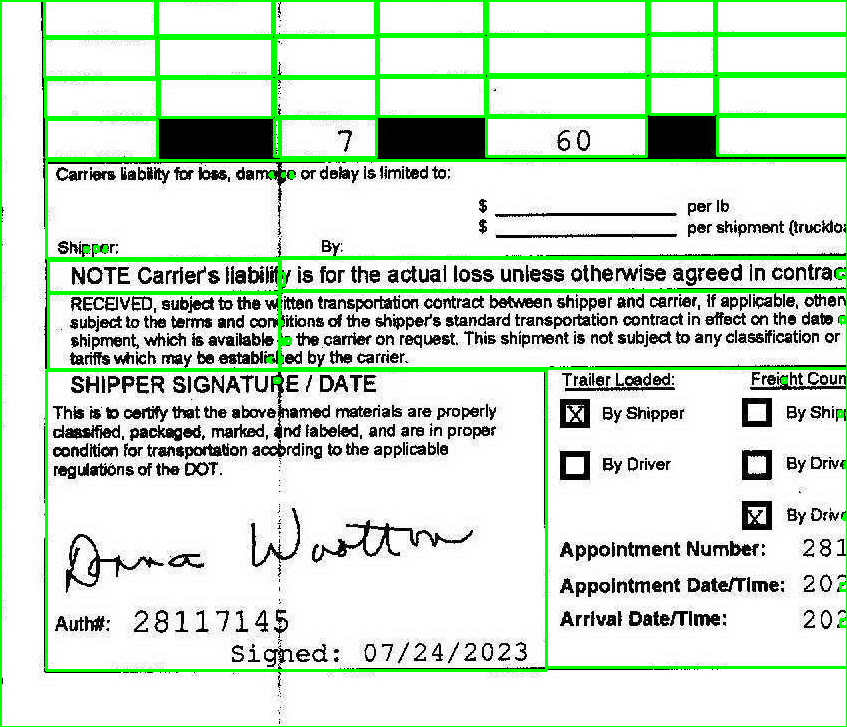

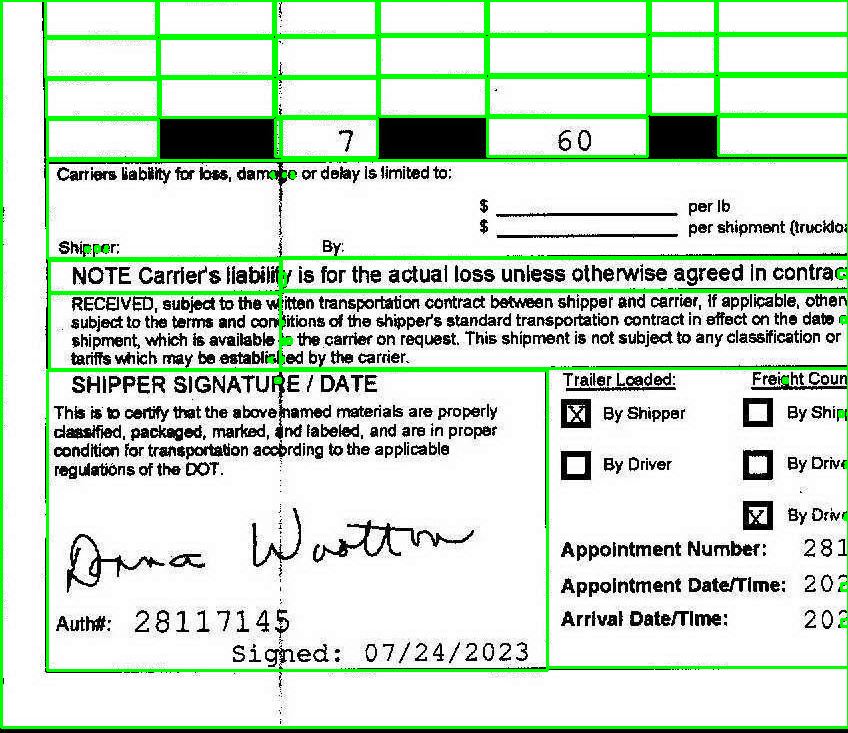

In [20]:
from PIL import Image
import pytesseract
import cv2
from IPython.display import display, Image as IPImage
# Load the image
image_path = 'sub_image_5.jpg'
img = cv2.imread(image_path)

# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Perform OCR to get the text
text = pytesseract.image_to_string(gray)

# Thresholding the image to get binary image (black and white)
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

# Finding contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Loop through contours and find the bounding box of the text
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Crop the region
    cropped_img = img[y:y+h, x:x+w]
    
    # Perform OCR on the cropped region
    cropped_gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    cropped_text = pytesseract.image_to_string(cropped_gray)
    
    # Check if "SHIPPER SIGNATURE" is in the cropped text
    if "SHIPPER SIGNATURE" in cropped_text.upper():  # Use upper() to make it case-insensitive
        # Save the cropped region with the bounding box
        cv2.imwrite('Shipper_signature.jpg', cropped_img)
        
        # Display the cropped image with bounding box
        _, encoded_img = cv2.imencode('.png', cropped_img)
        display(IPImage(data=encoded_img))
        
        break  # Exit the loop after finding the first occurrence

# Display the original image with bounding box (optional)
_, encoded_img = cv2.imencode('.png', img)
display(IPImage(data=encoded_img))

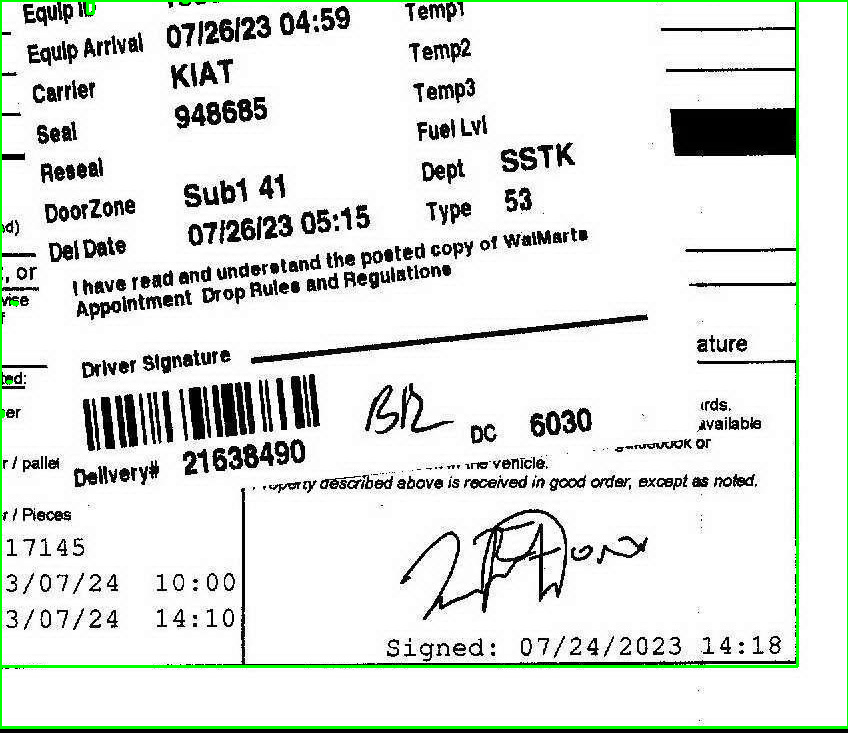

In [21]:
from PIL import Image
import pytesseract
import cv2
from IPython.display import display, Image as IPImage
# Load the image
image_path = 'sub_image_6.jpg'
img = cv2.imread(image_path)

# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Perform OCR to get the text
text = pytesseract.image_to_string(gray)

# Thresholding the image to get binary image (black and white)
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

# Finding contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Loop through contours and find the bounding box of the text
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Crop the region
    cropped_img = img[y:y+h, x:x+w]
    
    # Perform OCR on the cropped region
    cropped_gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    cropped_text = pytesseract.image_to_string(cropped_gray)
    
    # Check if "SHIPPER SIGNATURE" is in the cropped text
    if "CARRIER SIGNATURE" in cropped_text.upper():  # Use upper() to make it case-insensitive
        # Save the cropped region with the bounding box
        cv2.imwrite('Carrier_signature.jpg', cropped_img)
        
        # Display the cropped image with bounding box
        _, encoded_img = cv2.imencode('.png', cropped_img)
        display(IPImage(data=encoded_img))
        
        break  # Exit the loop after finding the first occurrence

# Display the original image with bounding box (optional)
_, encoded_img = cv2.imencode('.png', img)
display(IPImage(data=encoded_img))

In [22]:
import base64 

converted_shipper = ""
converted_carrier = "" 
  
with open("Shipper_signature.jpg", "rb") as image2string: 
    converted_shipper = base64.b64encode(image2string.read()) 
print(converted_shipper) 

with open("Carrier_signature.jpg", "rb") as image2string: 
    converted_carrier = base64.b64encode(image2string.read()) 
print(converted_carrier) 
  
with open('encode_shipper.bin', "wb") as file: 
    file.write(converted_shipper)

with open('encode_carrier.bin', "wb") as file: 
    file.write(converted_shipper)

b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCALXA08DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9Qf2N/wBjj9nD4q/s4+HfHvj74c/b9Wvzdfa7v+17yLfsvZol+WOZVGERRwB0z15r1L/h3l+x7/0SD/y4NQ/+SKi/4J6f8mg+Efrff+nG4r26vzDgzgzg/FcH5dWrZdQlOVCi5SdGm226cW2243bb1berZ+N+H3h9wFjeAs

In [23]:
import cv2
import pytesseract
from pytesseract import Output

# Read image using OpenCV
image = cv2.imread('sub_image_3.jpg')

# Preprocess image (grayscale and adaptive thresholding)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)

# Use pytesseract to do OCR on the image
custom_config = r'--oem 3 --psm 6'  # OEM and PSM settings
details = pytesseract.image_to_data(binary, output_type=Output.DICT, config=custom_config, lang='eng')

# Process OCR results
extracted_text = []
for i in range(len(details['text'])):
    if int(details['conf'][i]) > 0:  # Adjust confidence threshold as needed
        x, y, w, h = details['left'][i], details['top'][i], details['width'][i], details['height'][i]
        text = details['text'][i]
        extracted_text.append((text, (x, y, w, h)))

# Sort text based on the y-coordinate
extracted_text.sort(key=lambda x: x[1][1])

# Extract final text
final_text = ' '.join([text for text, _ in extracted_text])

print(final_text)


ge eT eer ARR — _— a SPECIAL — —__—_ CUSTOMERSORDE a ee ; ee i Tore CO eo ae (cr a enor fg | [| ff | |.


In [24]:
import io
from google.cloud import vision
from difflib import SequenceMatcher
from fuzzywuzzy import fuzz

# Assuming 'client' is your Google Vision API client
client = vision.ImageAnnotatorClient()

# Load image file
with io.open("sub_image_3.jpg", 'rb') as image_file:
    content = image_file.read()

# Construct an image object
image_v = vision.Image(content=content)

# Perform text detection
response = client.document_text_detection(image=image_v)
annotations = response.full_text_annotation

# Extract words and their bounding boxes
words = []
for page in annotations.pages:
    for block in page.blocks:
        for paragraph in block.paragraphs:
            for word in paragraph.words:
                word_text = ''.join([symbol.text for symbol in word.symbols])
                words.append((word_text, word.bounding_box.vertices))

# Sort words by their vertical position (top to bottom)
words.sort(key=lambda w: (w[1][0].y, w[1][0].x))

# Construct the detected text by reconstructing lines based on vertical position
detected_text = []
current_line = []
last_bottom = words[0][1][0].y

for word, vertices in words:
    if vertices[0].y > last_bottom + 5:  # New line threshold (adjust as needed)
        detected_text.append(' '.join(current_line))
        current_line = [word]
    else:
        current_line.append(word)
    
    last_bottom = vertices[2].y

# Append the last line
if current_line:
    detected_text.append(' '.join(current_line))

# Join all lines into a single string
detected_text = '\n'.join(detected_text)

# Print the reconstructed text
print(detected_text)


REC
HELPED INSTRUCTIONS SPECIAL RV
CUSTOMER ORDE
WEIGHT NUMBER # PKGS CUSTOMER ORDER
59.52 1004134546 7
GRAND 60 7 TOTAL CARRIER INF
HANDLING UNIT PACKAGE
Commodities requ WEIGHT TYPE H.M. QTY QTY TYPE marked X ) (
7 Ctn 59.52 CLOTHI


In [25]:
import re

# Function to extract numbers from text
PONUM = "0"
def extract_numbers(text):
    # Using regular expression to find all numbers
    numbers = re.findall(r'\b\d+\b', text)
    return numbers

# Initialize variables to store the largest number and its length
largest_number = None
largest_number_length = 0

# Iterate through each line of detected_text
for line in detected_text.splitlines():
    # Extract numbers from the line
    numbers_in_line = extract_numbers(line)
    
    # Iterate through extracted numbers
    for num_str in numbers_in_line:
        # Convert number string to integer
        try:
            num = int(num_str)
        except ValueError:
            continue
        
        # Check if number is between 8 to 20 digits
        num_length = len(num_str)
        if num_length >= 8 and num_length <= 20:
            # Update largest number if found a larger one
            if num_length > largest_number_length or (num_length == largest_number_length and num > largest_number):
                largest_number = num
                largest_number_length = num_length

# Print the largest number found
if largest_number is not None:
    PONUM = largest_number
    print("Largest number between 8-20 digits:", largest_number)
else:
    print("No number between 8-20 digits found.")


Largest number between 8-20 digits: 1004134546


In [26]:
BOL_data = {
    "date": BOL_date,
    "BOL_Number": BOLNo,
    "TLR": TLR,
    "SEAL_NUM": SEAL,
    "PONUM": PONUM,
    "Shipper_Signature": converted_shipper,
    "Carrier_Signature": converted_carrier
}

print(BOL_data)

{'date': '07/24/2023', 'BOL_Number': '_07051430019633860', 'TLR': '1009', 'SEAL_NUM': '0050110', 'PONUM': 1004134546, 'Shipper_Signature': b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCALXA08DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9Qf2N/wBjj9nD4q/s4+HfHvj74c/